In [1]:
import os 
import re
import pandas as pd
import numpy as np 
from scipy import stats
from matplotlib import pyplot as plt
import essentia.standard as es
from IPython.display import display, Markdown
import seaborn as sns
import math
import plotly.graph_objects as go

In [2]:
data_folder = 'data/data/'
folders = os.listdir(data_folder)
columns = ['mood', 'role', 'concept', 'genre']
pattern = r'_(An|A)_(?P<mood>\w+)_(?P<genre>\w+)_(?P<role>\w+)_(?P<concept>\w+)'

all_audios = []
for folder in folders:
    match = re.match(pattern, folder)
    if match:
        descriptor = match.groupdict()
        audios = os.listdir(data_folder+folder)
        for audio in audios:
            audio_pattern = folder + r'_(\d+)\.wav$'
            audio_match = re.match(audio_pattern, audio)
            if audio_match:
                audio_number = audio_match.group(1)
                path = os.path.join(data_folder,folder,audio)
                all_audios.append({**descriptor, 'audio_number': audio_number, 'path':path})

data = pd.DataFrame(all_audios)
display(data.describe(include='all'))

mood genre        role concept audio_number  \
count      130   130         130     130          130   
unique       7     2           1       1           10   
top     tender  Rock  soundtrack    song            9   
freq        20    70         130     130           13   

                                                     path  
count                                                 130  
unique                                                130  
top     data/data/_A_tender_Rock_soundtrack_song/_A_te...  
freq                                                    1

In [3]:
# diagonal_pairs = [['happy' , 'sad'], ['exciting', 'sad'], ['funny', 'sad'], ['tender', 'angry'], ['tender', 'scary']]
# same_pairs = [['happy', 'exciting'], ['happy', 'funny'], ['exciting', 'funny'], ['angry', 'scary']]
# same_val_pairs = [['happy', 'tender'], ['exciting', 'tender'], ['funny', 'tender'], ['angry', 'sad'], ['scary', 'sad']]
# same_arou_pairs = [['happy', 'angry'], ['happy', 'scary'], ['funny', 'angry'], ['funny', 'scary'], ['exciting', 'angry'], ['exciting', 'scary'], ['sad', 'tender']]

diagonal_pairs = [['happy' , 'sad'], ['tender', 'angry']]
horizontal_pairs = [['happy', 'angry'], ['sad', 'tender']]
vertical_pairs = [['happy', 'tender'], ['angry', 'sad']]

In [4]:
def calculate_essentia_features_statistics(df):
    essentia_features = []
    # Iterate over the rows of the DataFrame
    for i, row in df.iterrows():
        # Extract the features using Essentia
        features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'], rhythmStats=['mean', 'stdev'], tonalStats=['mean', 'stdev'])(row['path'])

        essentia_features.append(features)

    return essentia_features

In [5]:
essentia_features_statistics = calculate_essentia_features_statistics(data)

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, a

In [6]:
relevant_features = [
    'lowlevel.pitch_salience.mean', # melody
    'lowlevel.pitch_salience.stdev', # melody

    'tonal.hpcp_entropy.mean', # harmony
    'tonal.hpcp_entropy.stdev', # harmony
    'tonal.chords_number_rate', # harmony
    'tonal.chords_changes_rate', # harmony
    'tonal.key_krumhansl.scale', # harmony

    'lowlevel.average_loudness', # dynamic

    'lowlevel.spectral_centroid.mean', # timbre
    'lowlevel.spectral_centroid.stdev', # timbre
    'lowlevel.spectral_kurtosis.mean', # timbre
    'lowlevel.spectral_kurtosis.stdev', # timbre
    'lowlevel.dissonance.mean', # timbre
    'lowlevel.dissonance.stdev', # timbre

    'rhythm.onset_rate', # rhythm
    'rhythm.bpm', # rhythm
    'rhythm.bpm_histogram' # rhythm
]

categorical_features = ['tonal.key_krumhansl.scale', 'tonal.chords_key']


In [7]:
data_relevant_features = pd.DataFrame([{feature: essentia_features_statistics[i][feature] for feature in relevant_features} for i in range(len(essentia_features_statistics))])

In [8]:
def calculate_tempo_entropy(row):
    bpm_histogram = row['rhythm.bpm_histogram']
    entropy_bpm = stats.entropy(bpm_histogram)
    row['rhythm.bpm_histogram_entropy'] = entropy_bpm
    return row

data_relevant_features = data_relevant_features.apply(calculate_tempo_entropy, axis=1)
data_relevant_features = data_relevant_features.drop('rhythm.bpm_histogram', axis=1)

In [9]:
# Add mood to the DataFrame
data_relevant_features = pd.concat([data['mood'], data_relevant_features], axis=1)

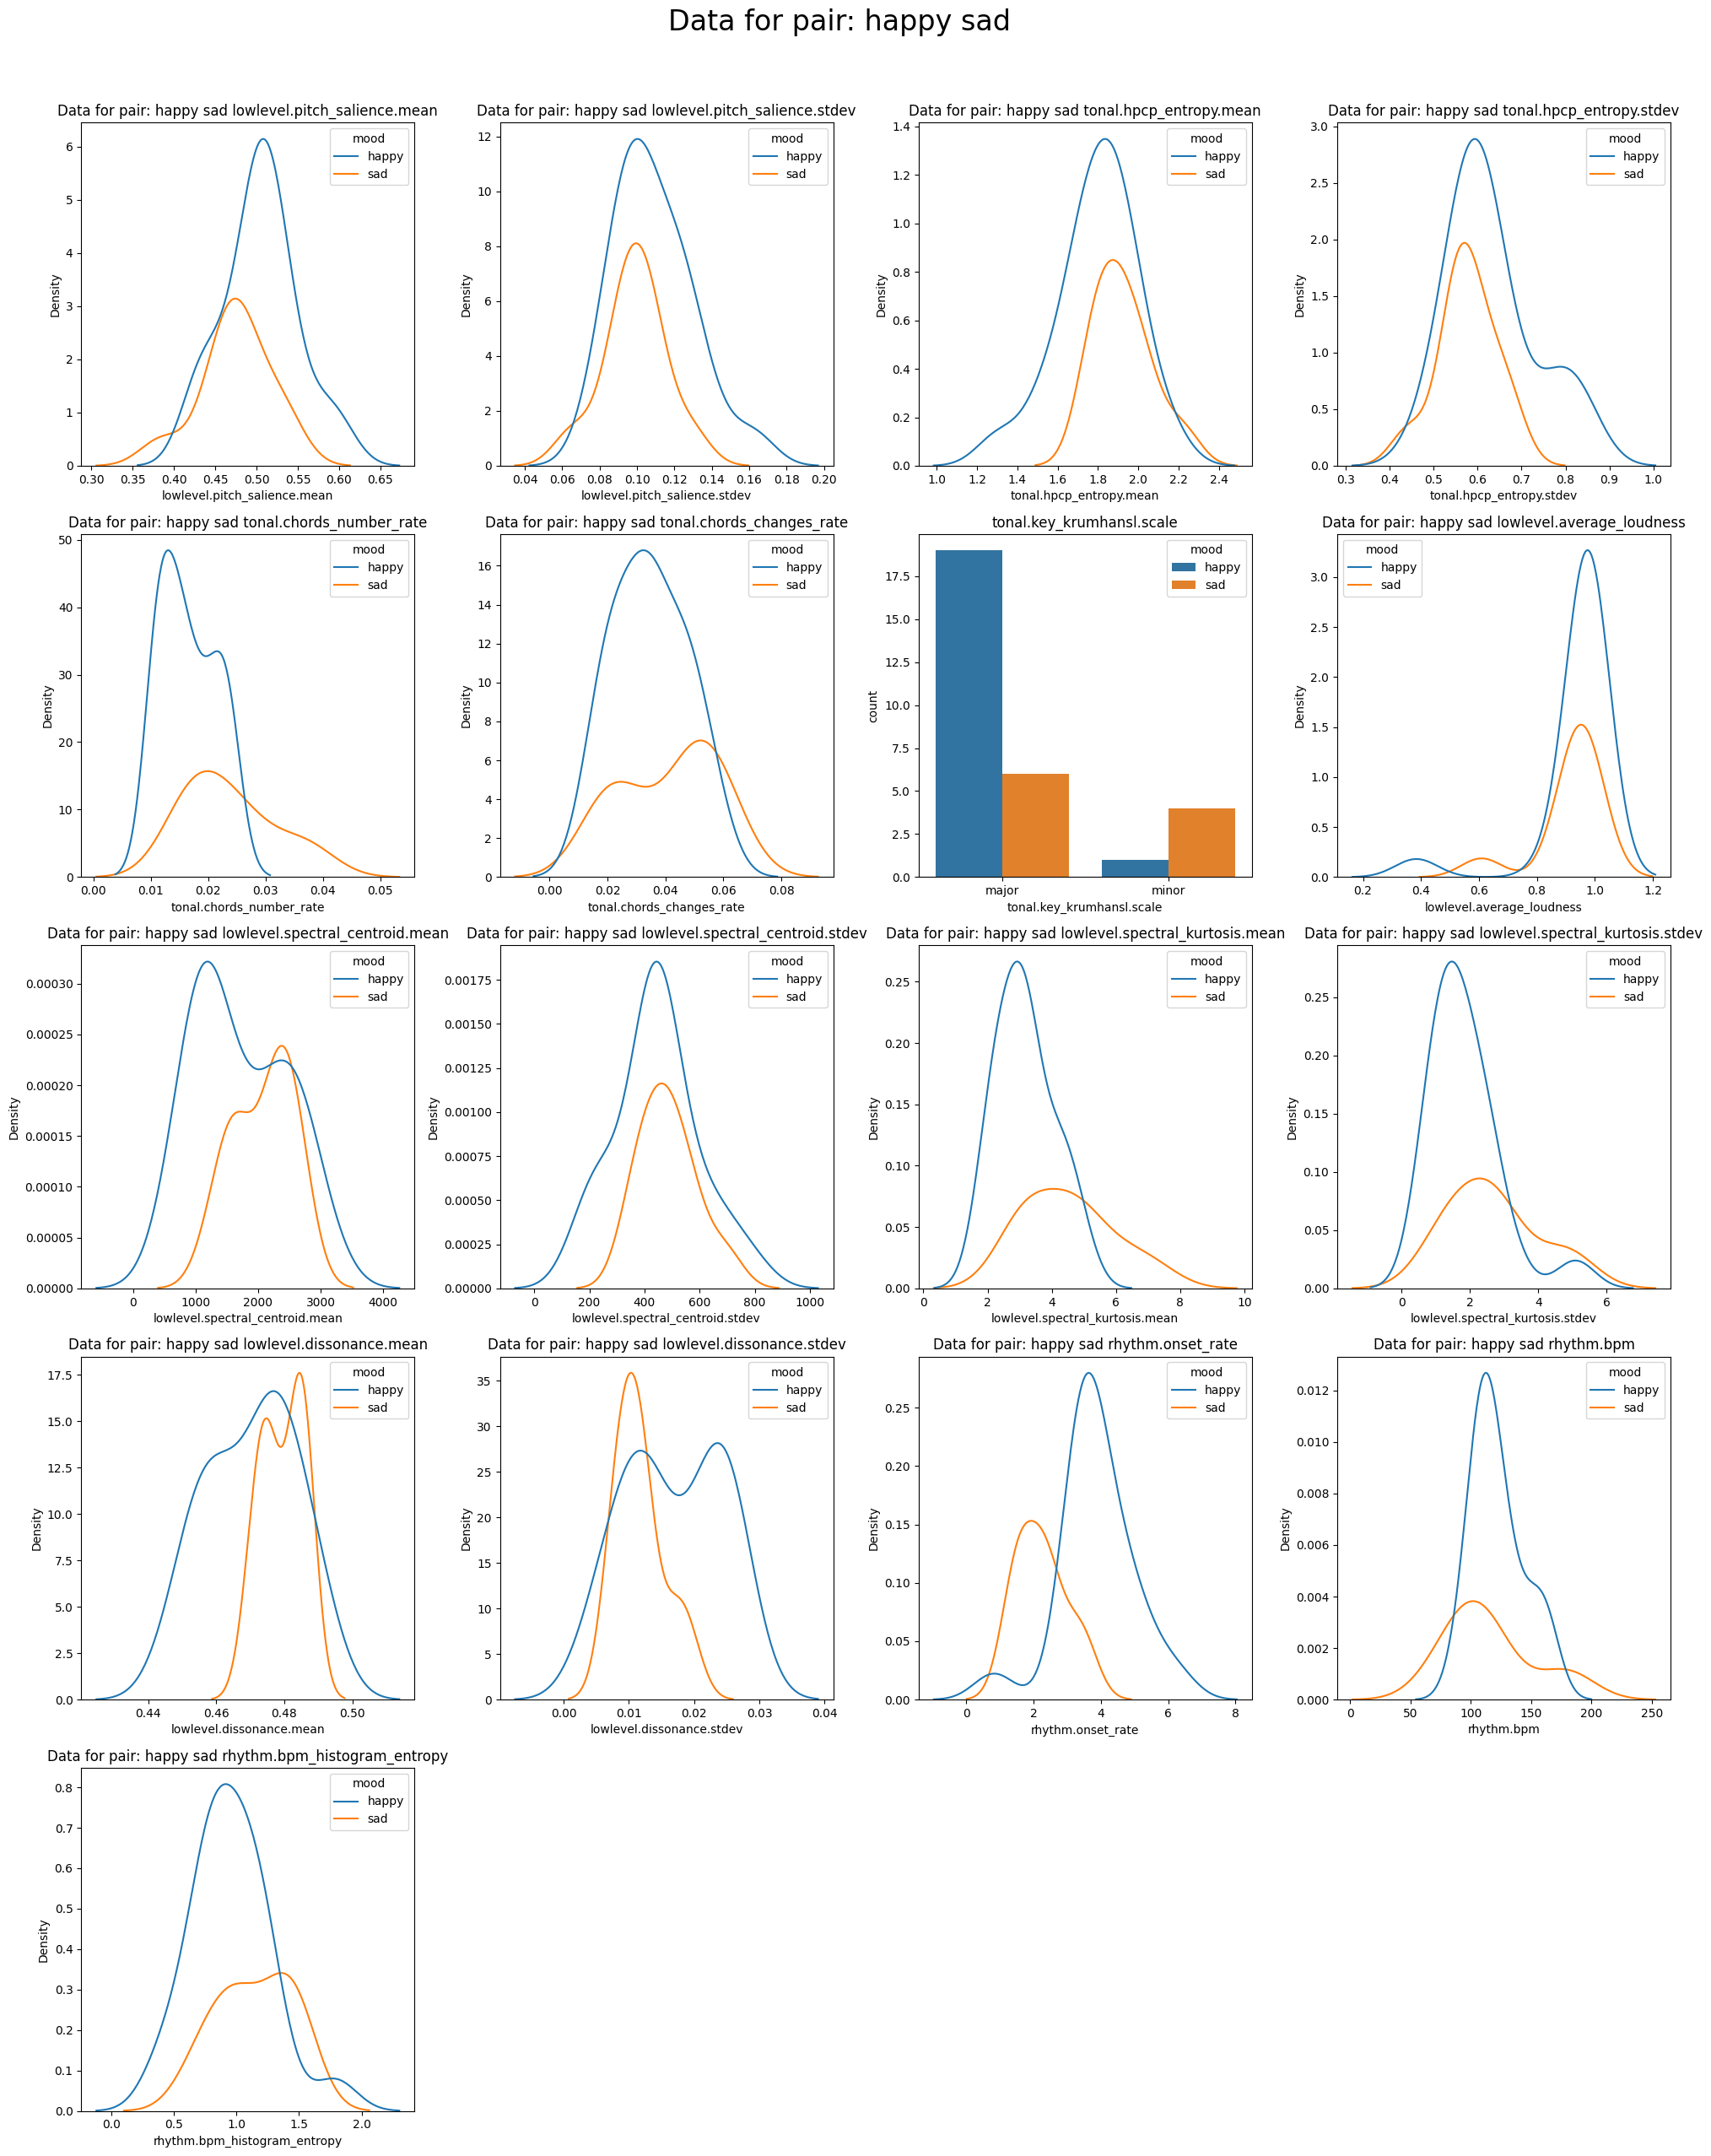

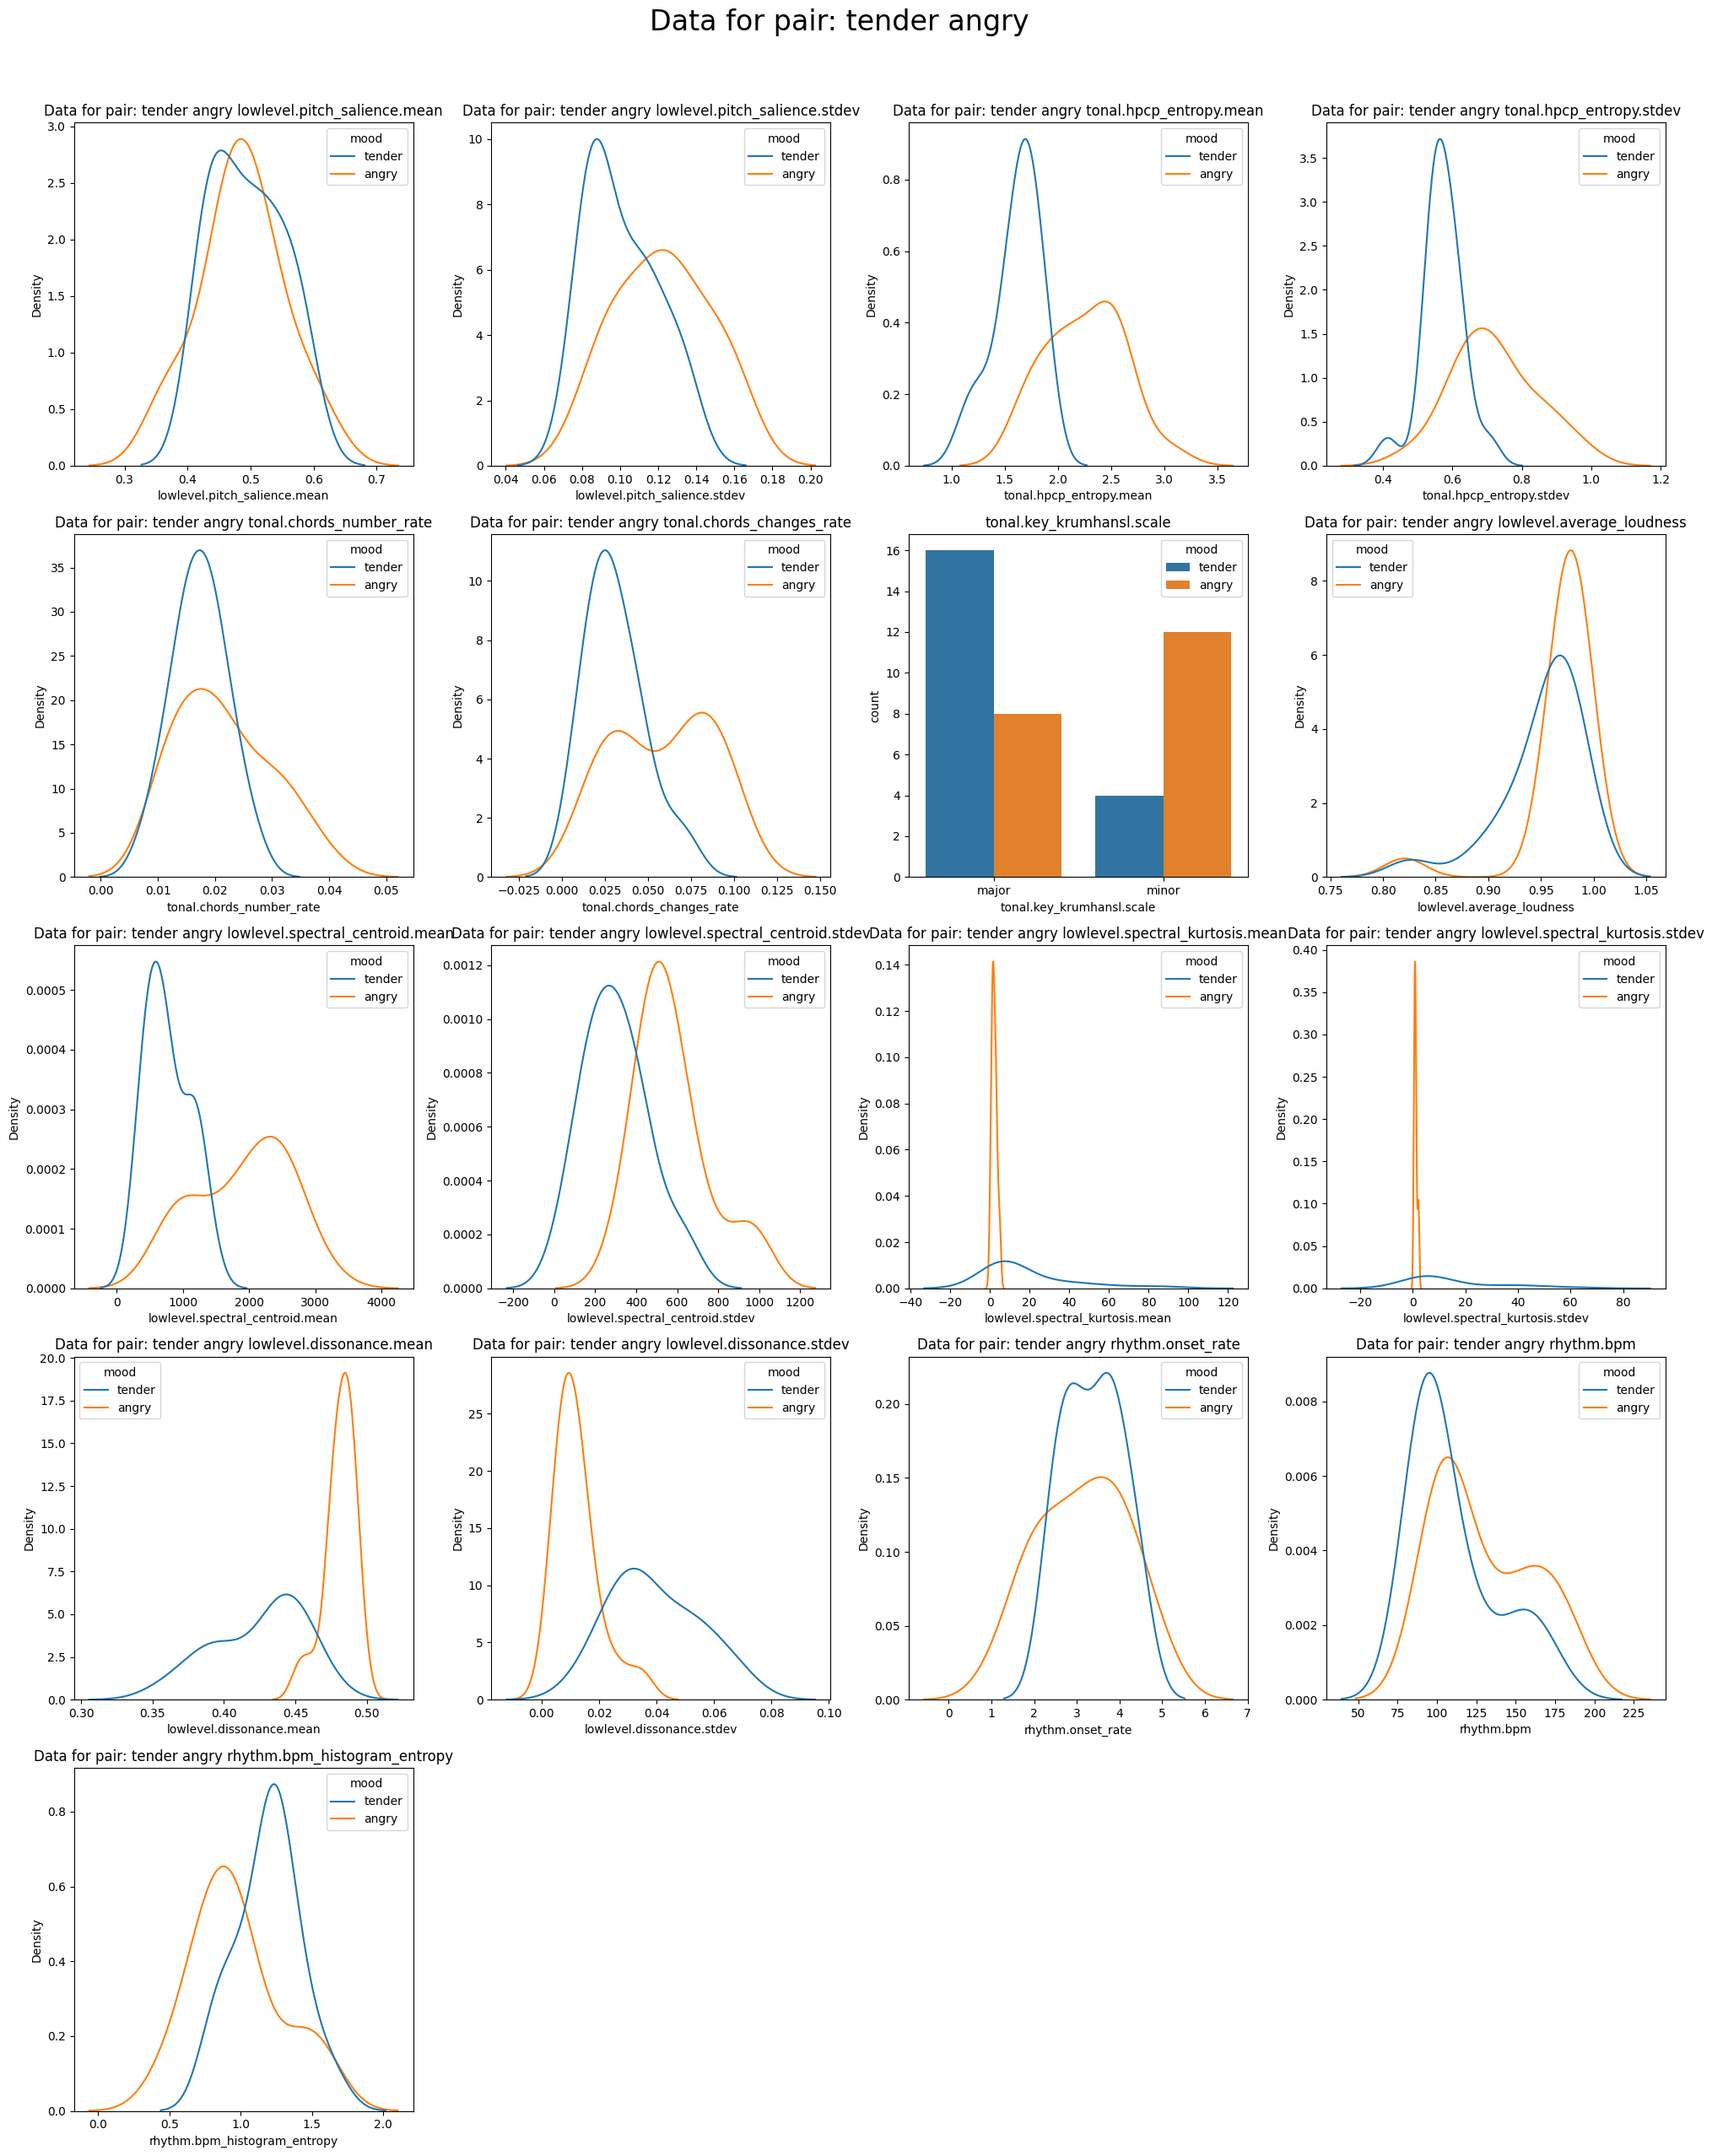

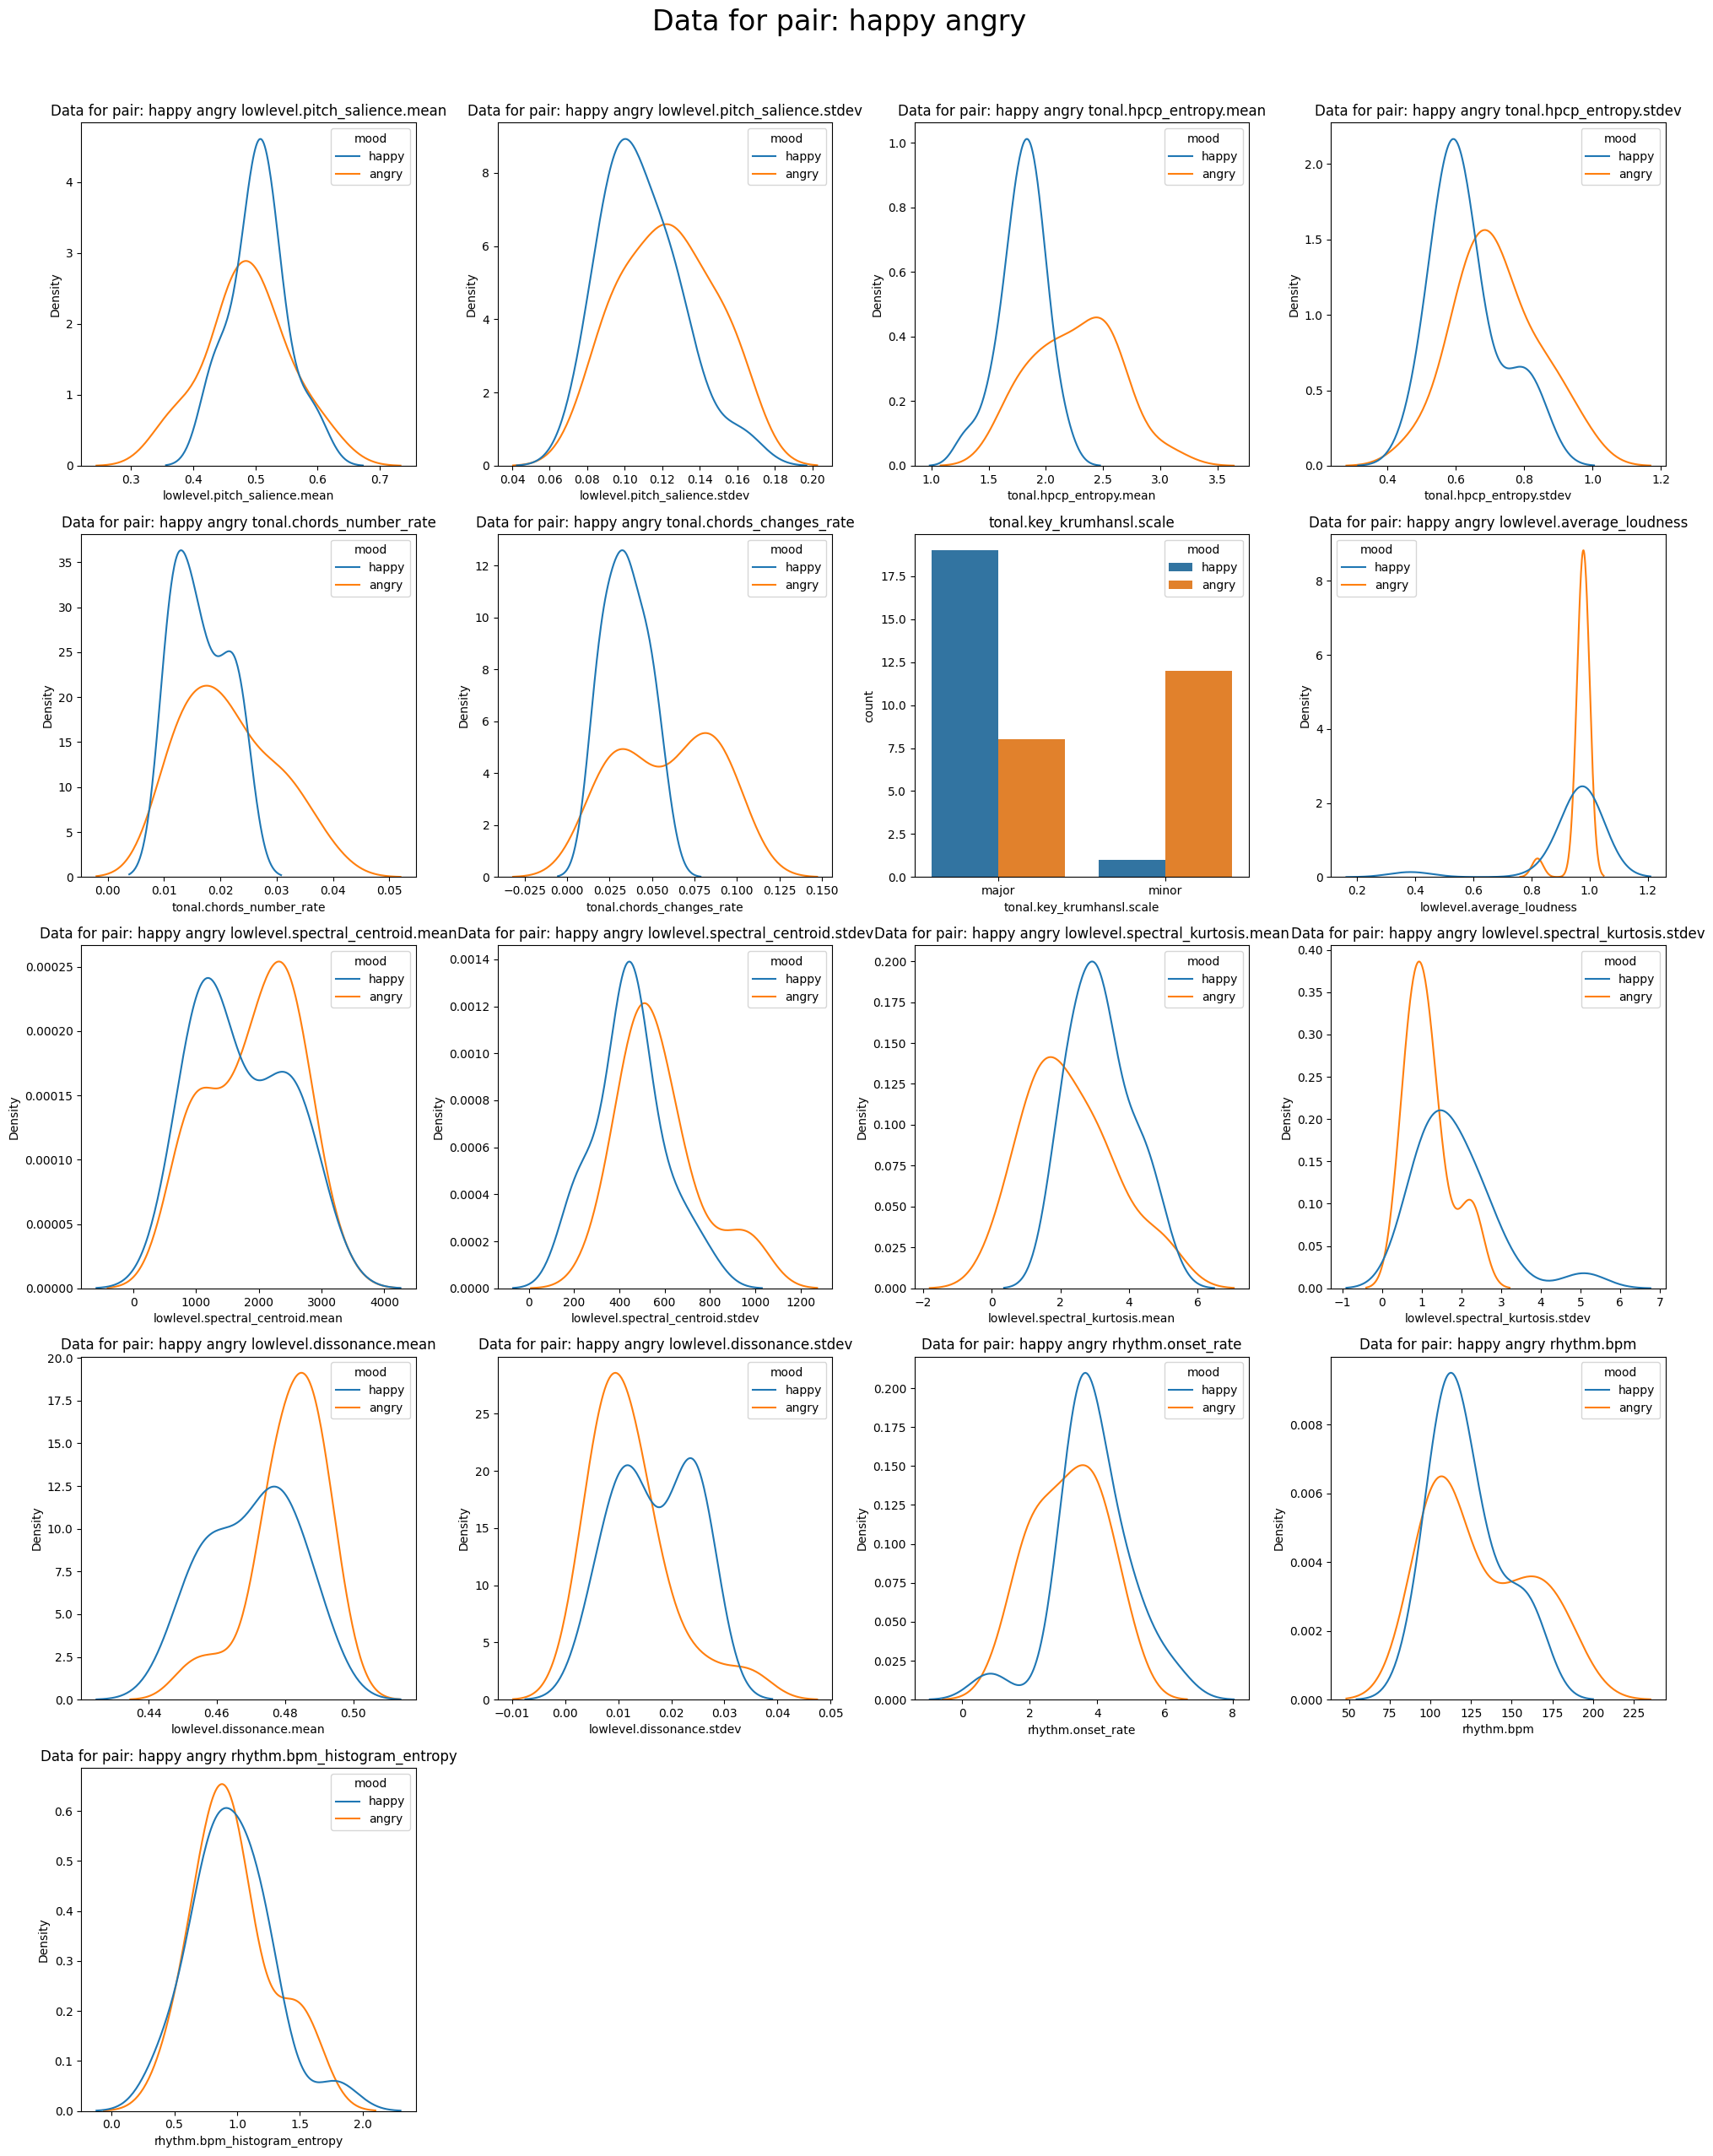

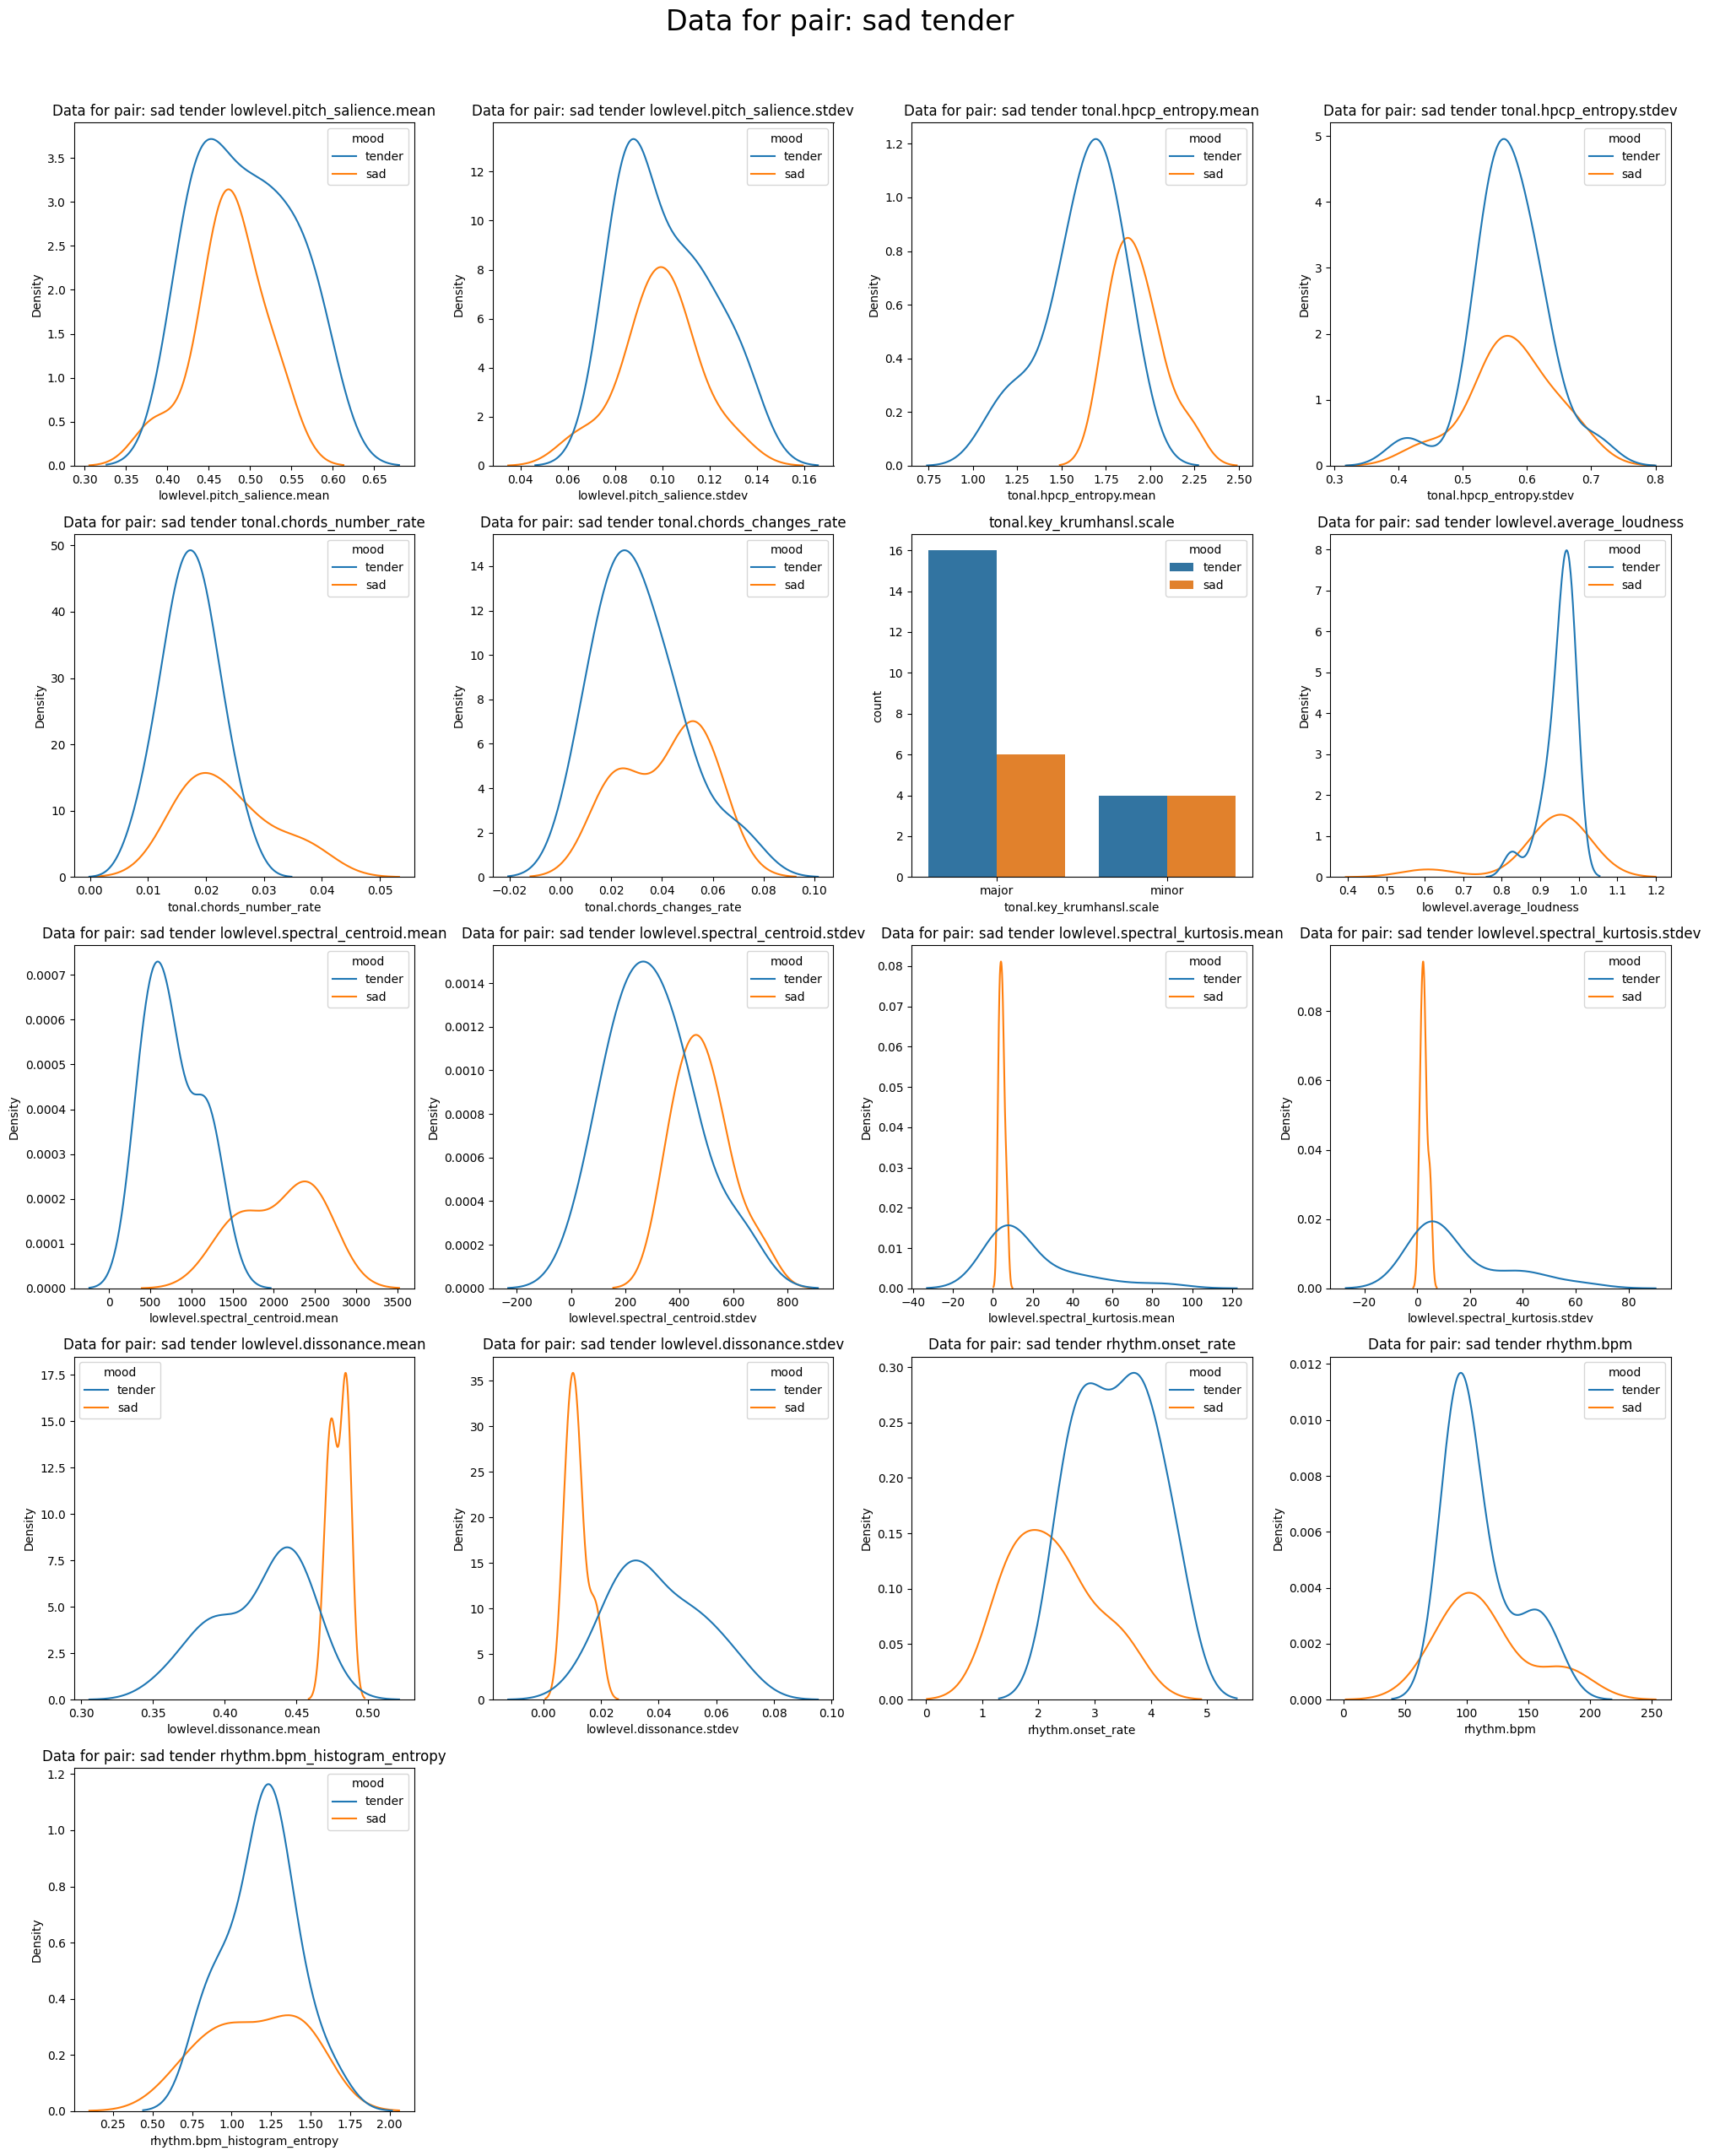

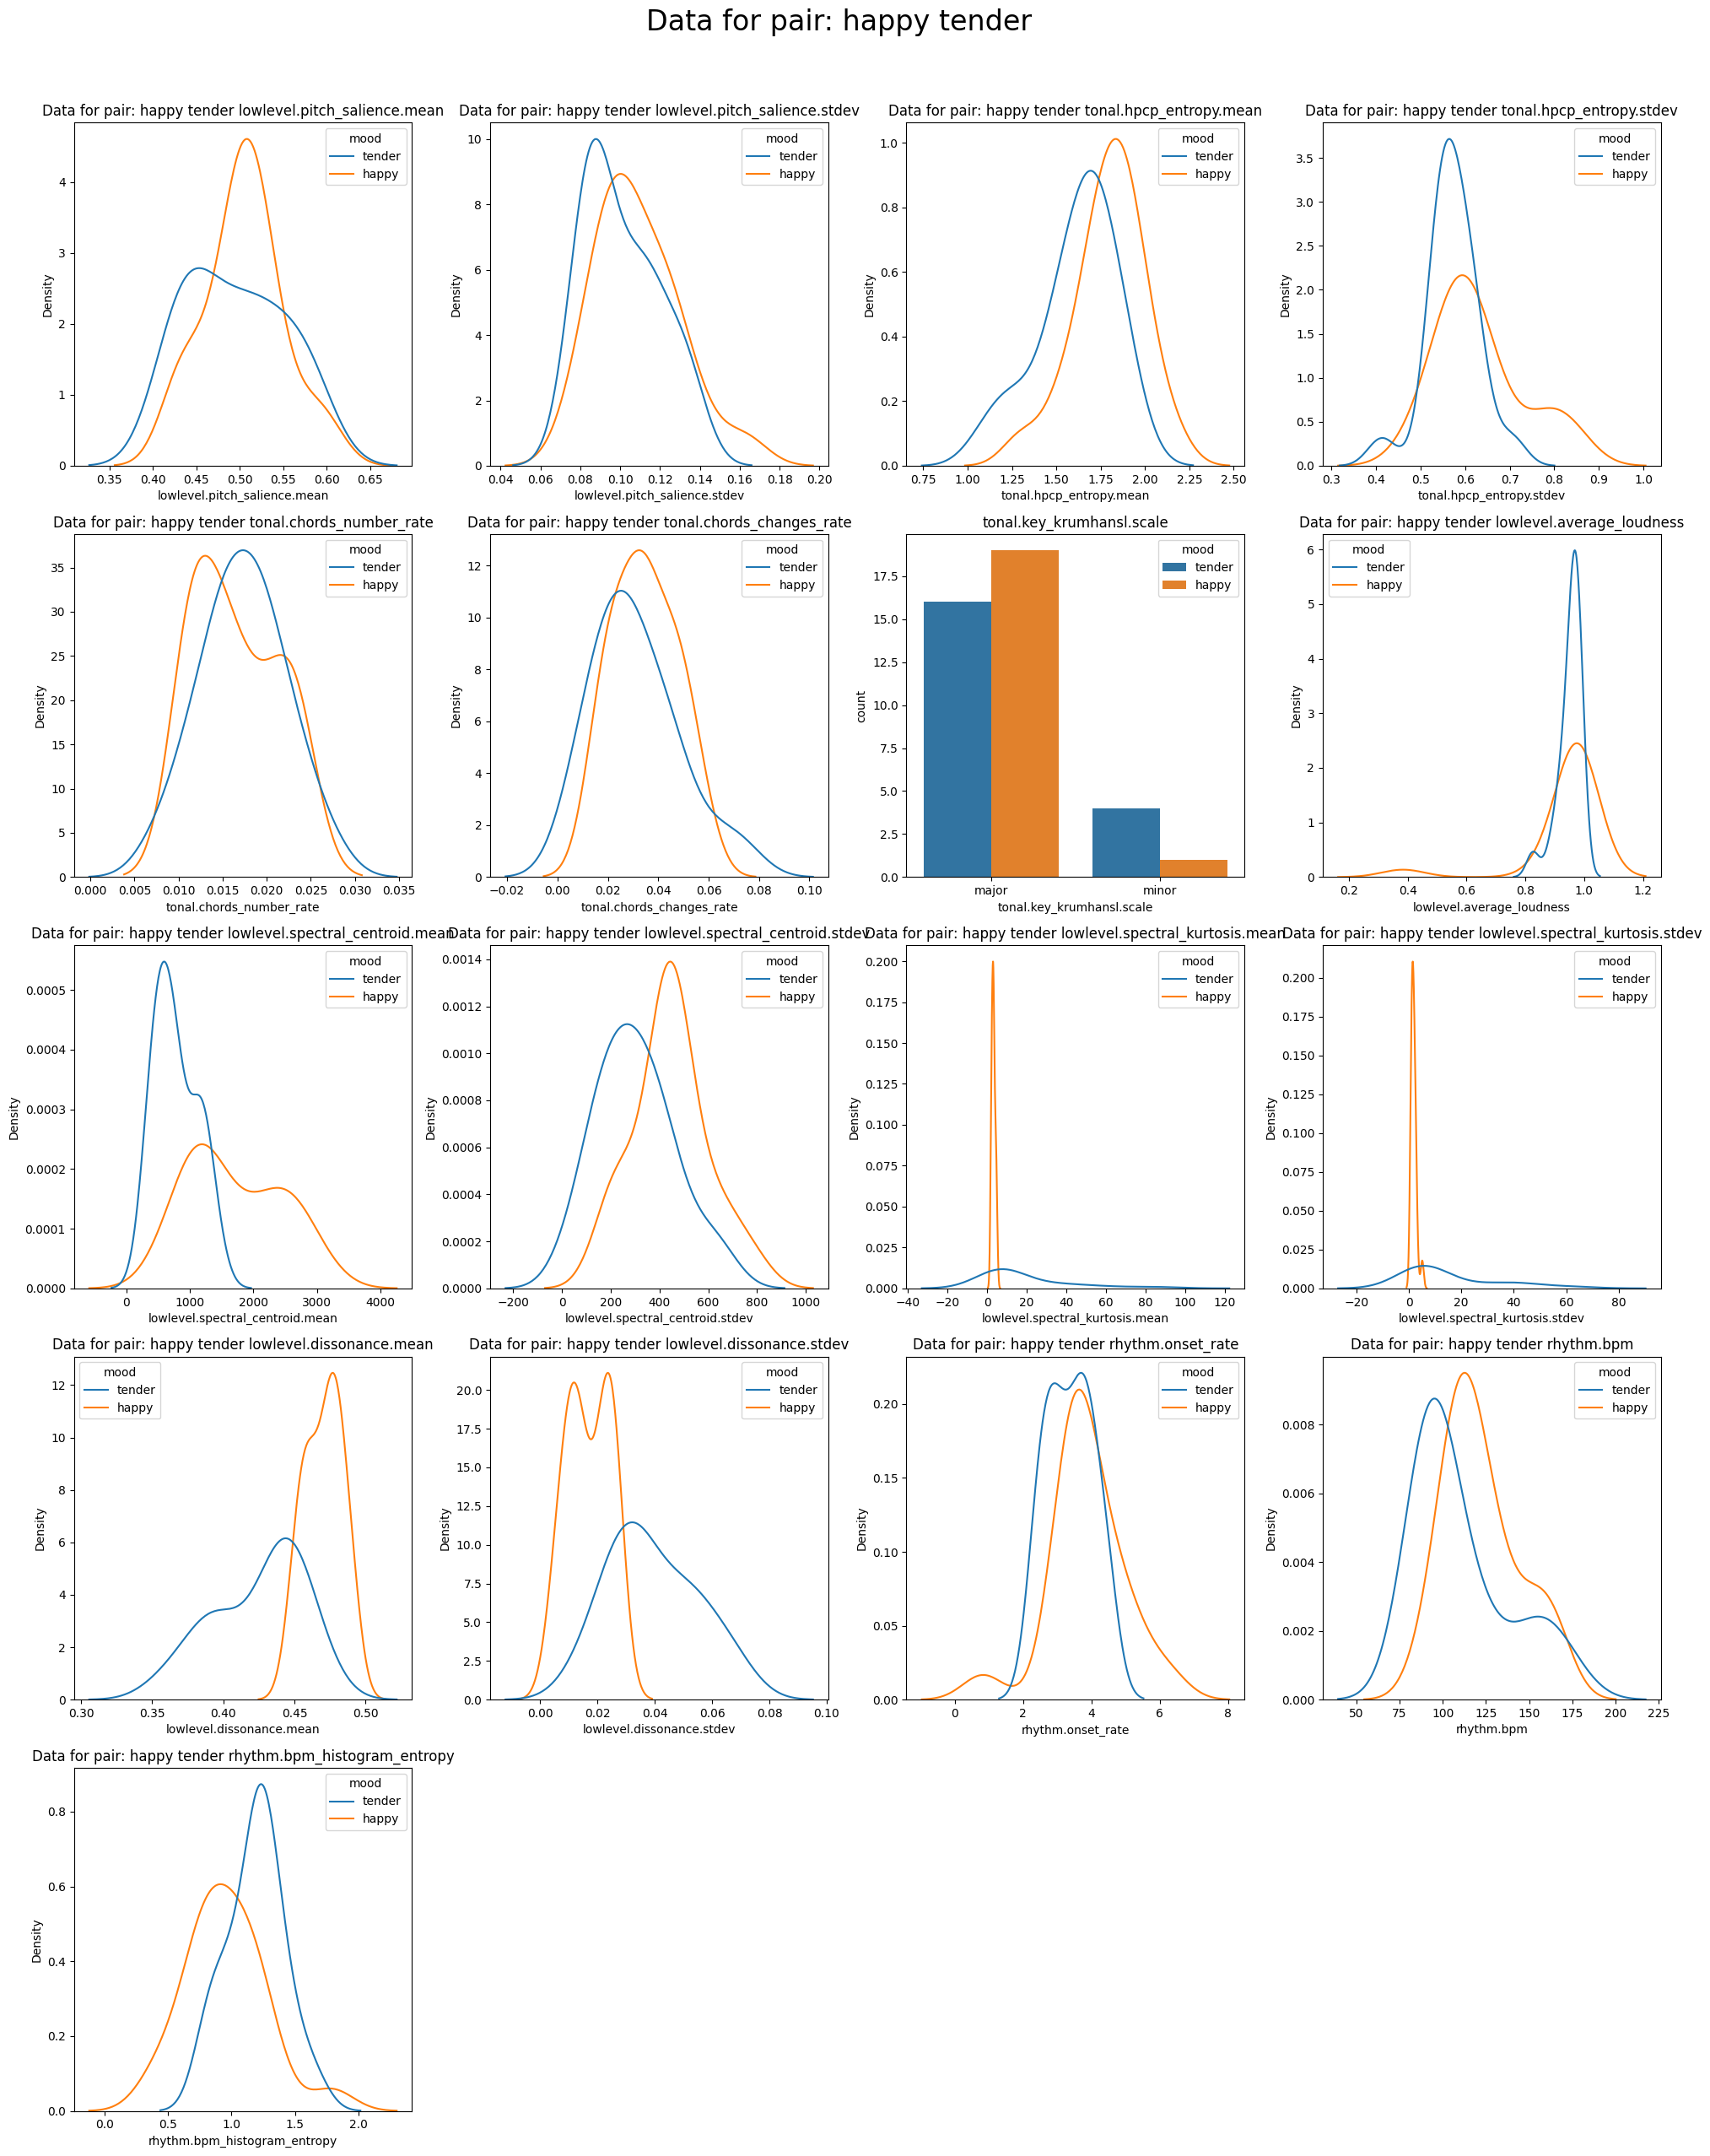

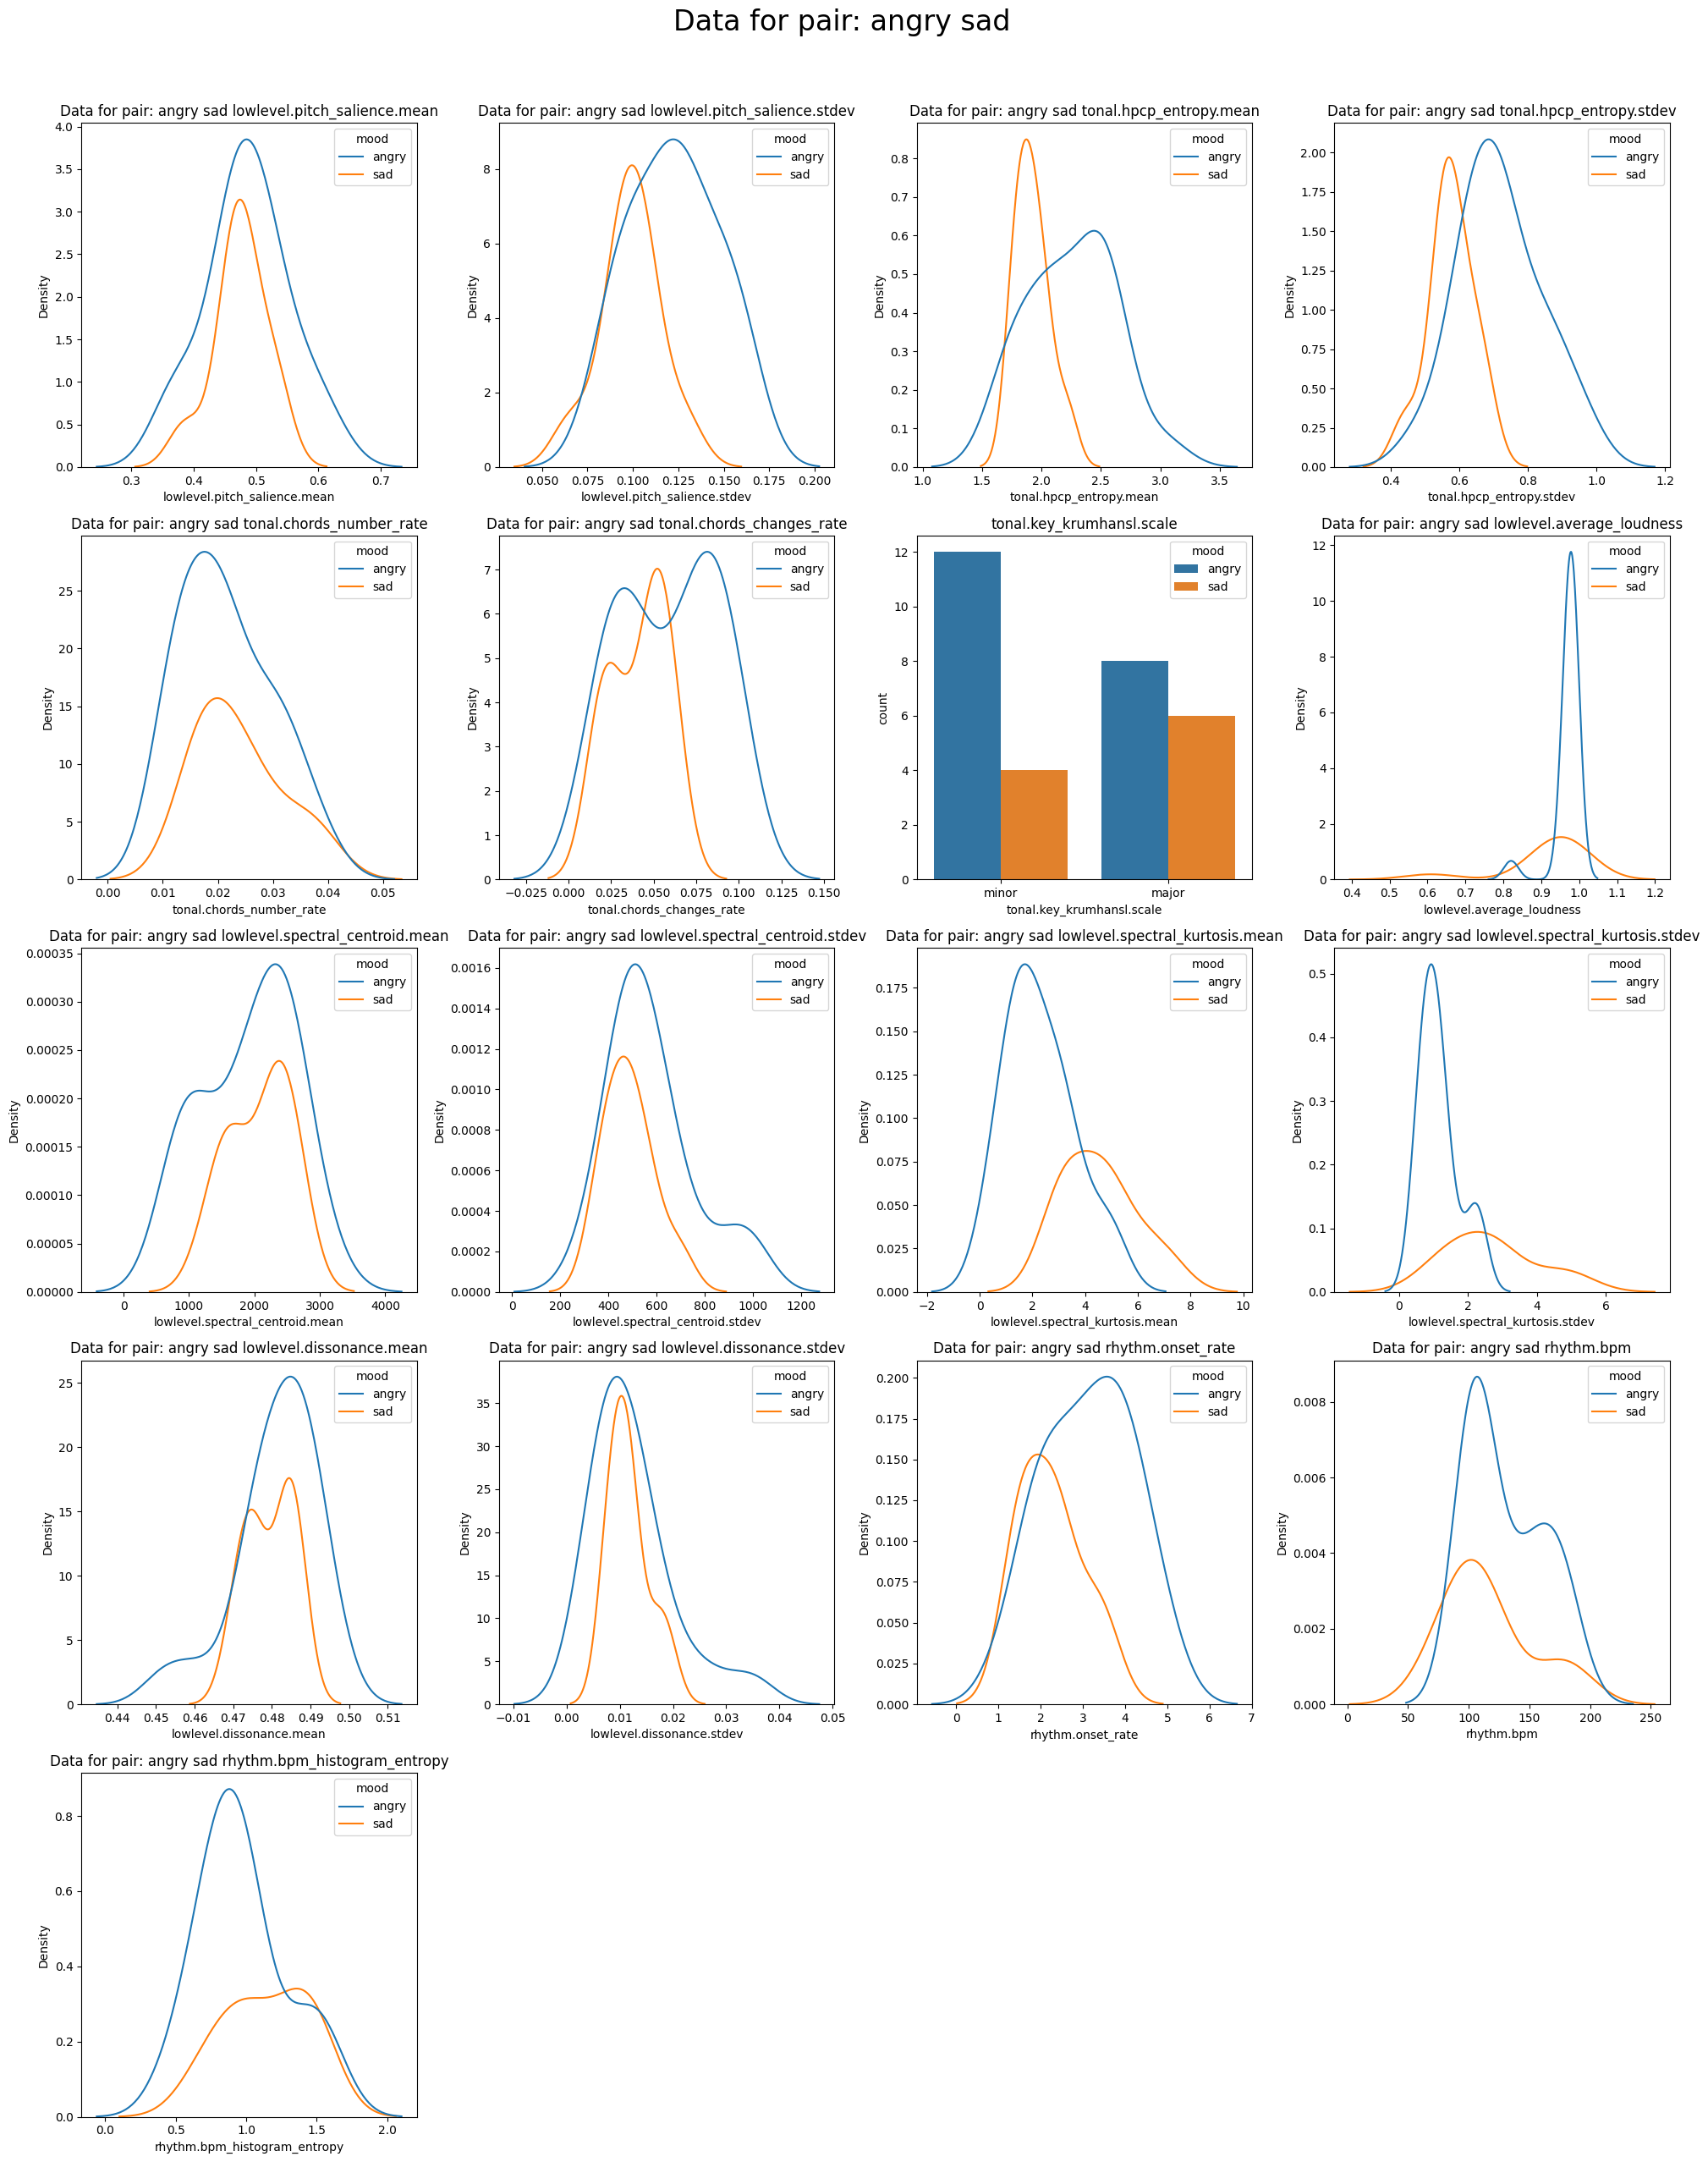

In [10]:
for pairs in [diagonal_pairs, horizontal_pairs, vertical_pairs]:
    
    for pair in pairs:
        df_filtered = data_relevant_features[(data_relevant_features['mood'] == pair[0]) | (data_relevant_features['mood'] == pair[1])]
        
        plot_features = [feature for feature in relevant_features if feature != 'rhythm.bpm_histogram']
        plot_features += ['rhythm.bpm_histogram_entropy']

        num_features = len(plot_features)
        num_cols = 4
        num_rows = math.ceil(num_features / num_cols)

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
        axs = axs.ravel()

        fig.suptitle('Data for pair: {} {}'.format(pair[0], pair[1]), fontsize=24, y=1.02)

        for i, feature in enumerate(plot_features):

            if feature in categorical_features:
                sns.countplot(data=df_filtered, x=feature, hue='mood', ax=axs[i])
                axs[i].set_title(feature)
            elif feature == 'rhythm.bpm_histogram':
                pass
            else:
                sns.kdeplot(data=df_filtered, x=feature, hue='mood', ax=axs[i])
                axs[i].set_title("Data for pair: " + pair[0] + ' ' + pair[1] + ' ' + feature)
        
        for j in range(i + 1, num_rows*num_cols):
            fig.delaxes(axs[j])
        
        plt.tight_layout()
        plt.show()


In [11]:
def calculate_statistics_pairs(pairs, features, categorical_features):
    shapiro_results = []
    significance_results = []
    levene_results = []

    for pair in pairs:
        df_moods = data_relevant_features[(data_relevant_features['mood'] == pair[0]) | (data_relevant_features['mood'] == pair[1])]
        df_mood_a = data_relevant_features[(data_relevant_features['mood'] == pair[0])]
        df_mood_b = data_relevant_features[(data_relevant_features['mood'] == pair[1])]
        shapiro_pair_results = []
        significance_pair_results = []
        levene_pair_results = []

        for feature in features:
            if feature != 'rhythm.bpm_histogram':
                data_feature_a = df_mood_a[feature]
                data_feature_b = df_mood_b[feature]

                if feature not in categorical_features:
                    w_statistic_a, p_value_a = stats.shapiro(data_feature_a)
                    is_normal_a = p_value_a > 0.05 

                    w_statistic_b, p_value_b = stats.shapiro(data_feature_b)
                    is_normal_b = p_value_b > 0.05 

                    shapiro_pair_results.append({'Feature': feature, 'Mood A': pair[0], 'W-statistic A': w_statistic_a, 'P-value A': p_value_a, 'Normal Distribution A': is_normal_a, 'Mood B': pair[1], 'W-statistic B': w_statistic_b, 'P-value B': p_value_b, 'Normal Distribution B': is_normal_b})

                    levene_stat, p_value = stats.levene(data_feature_a, data_feature_b)
                    is_equal_variance = p_value > 0.05

                    levene_pair_results.append({'Feature': feature, 'Levene-statistic': levene_stat, 'P-value': p_value, 'Equal Variance': is_equal_variance})

                    if(is_normal_a and is_normal_b):
                        t_statistic, p_value = stats.ttest_ind(data_feature_a, data_feature_b, equal_var=is_equal_variance)
                        is_significant = p_value < 0.05
                        significance_pair_results.append({'Feature': feature, 'Test': ('Student t-test' if is_equal_variance else 'Welch t-Test'), 'Statistic': t_statistic, 'P-value': p_value, 'Significant': is_significant})
                    else:
                        mann_whitney_u_statistic, p_value = stats.mannwhitneyu(data_feature_a, data_feature_b)
                        is_significant = p_value < 0.05
                        significance_pair_results.append({'Feature': feature, 'Test': 'Mann-Whitney U-test', 'Statistic': mann_whitney_u_statistic, 'P-value': p_value, 'Significant': is_significant})
                else:
                    chi2_stat, p_value, dof, ex = stats.chi2_contingency(pd.crosstab(df_moods['mood'], df_moods[feature]))
                    is_significant = p_value < 0.05
                    significance_pair_results.append({'Feature': feature, 'Test': 'Chi-Square Test', 'Statistic': chi2_stat, 'P-value': p_value, 'Significant': is_significant})

        shapiro_results.append(pd.DataFrame(shapiro_pair_results))
        significance_results.append(pd.DataFrame(significance_pair_results))
        levene_results.append(pd.DataFrame(levene_pair_results))

    return significance_results, shapiro_results, levene_results


In [12]:
# feature_names = {
#     'rhythm.bpm': 'Tempo',
#     'lowlevel.spectral_kurtosis.mean': 'Spectral Kurtosis Mean',
#     'lowlevel.spectral_kurtosis.stdev': 'Spectral Kurtosis Std Dev',
#     'tonal.chords_number_rate': 'Chords Number Rate',
#     'tonal.chords_changes_rate': 'Chord Changes Rate',
#     'lowlevel.dissonance.mean': 'Dissonance Mean', 
#     'lowlevel.dissonance.stdev': 'Dissonance Std Dev', 
#     'lowlevel.average_loudness': 'Average Loudness',
#     'lowlevel.pitch_salience.mean': 'Pitch Salience Mean',
#     'lowlevel.pitch_salience.stdev': 'Pitch Salience Std Dev', 
#     'rhythm.onset_rate': 'Onset Rate', 
#     'lowlevel.spectral_centroid.mean': 'Spectral Centroid Mean',
#     'lowlevel.spectral_centroid.stdev': 'Spectral Centroid Std Dev',
#     'tonal.hpcp_entropy.mean': 'HPCP Entropy Mean',
#     'tonal.hpcp_entropy.stdev': 'HPCP Entropy Std Dev',
#     'tonal.key_krumhansl.scale': 'Scale',
#     'tonal.chords_key': 'Key',
#     'rhythm.bpm_histogram_entropy': 'Tempo Histogram Entropy'
# }

feature_names = {
    'rhythm.bpm': 'Tempo',
    'lowlevel.spectral_kurtosis.mean': 'Spec Kurt',
    'lowlevel.spectral_kurtosis.stdev': 'Spec Kurt Std',
    'tonal.chords_number_rate': 'Chords<br>Num Rate',
    'tonal.chords_changes_rate': 'Chords<br>Chg Rate',
    'lowlevel.dissonance.mean': 'Dissonance', 
    'lowlevel.dissonance.stdev': 'Dissonance Std', 
    'lowlevel.average_loudness': 'Avg<br>Loudness',
    'lowlevel.pitch_salience.mean': 'Pitch<br>Sal',
    'lowlevel.pitch_salience.stdev': 'Pitch<br>Sal Std', 
    'rhythm.onset_rate': 'Onset Rate', 
    'lowlevel.spectral_centroid.mean': 'Spec<br>Cent',
    'lowlevel.spectral_centroid.stdev': 'Spec<br>Cent<br>Std',
    'tonal.hpcp_entropy.mean': 'HPCP Ent',
    'tonal.hpcp_entropy.stdev': 'HPCP Ent Std',
    'tonal.key_krumhansl.scale': 'Scale',
    'rhythm.bpm_histogram_entropy': 'Tempo<br>Hist Ent'
}

In [13]:
categorical_features = ['tonal.key_krumhansl.scale', 'tonal.chords_key']
features = [feature for feature in relevant_features if feature != 'rhythm.bpm_histogram']
features.extend(['rhythm.bpm_histogram_entropy'])

diagonal_significance_results, diagonal_shapiro_results, diagonal_levene_results = calculate_statistics_pairs(diagonal_pairs, features, categorical_features)
horizontal_significance_results, horizontal_shapiro_results, horizontal_levene_results = calculate_statistics_pairs(horizontal_pairs, features, categorical_features)
vertical_significance_results, vertical_shapiro_results, vertical_levene_results = calculate_statistics_pairs(vertical_pairs, features, categorical_features)


In [14]:
movements = ['diagonal', 'horizontal', 'vertical']
pairs = [diagonal_pairs, horizontal_pairs, vertical_pairs]

for i, results in enumerate([diagonal_significance_results, horizontal_significance_results, vertical_significance_results]):
    display(Markdown('**Significance results for {} movement**'.format(movements[i])))
    for index, result in enumerate(results):
        display(Markdown('**Significance results for pair: {} {}**'.format(pairs[i][index][0], pairs[i][index][1])))
        display(Markdown('```'))
        display(result)
        display(Markdown('```'))


**Significance results for diagonal movement**

**Significance results for pair: happy sad**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    1.776326   
1      lowlevel.pitch_salience.stdev       Student t-test    1.352464   
2            tonal.hpcp_entropy.mean       Student t-test   -1.838722   
3           tonal.hpcp_entropy.stdev       Student t-test    1.634009   
4           tonal.chords_number_rate  Mann-Whitney U-test   43.000000   
5          tonal.chords_changes_rate       Student t-test   -1.207321   
6          tonal.key_krumhansl.scale      Chi-Square Test    3.630000   
7          lowlevel.average_loudness  Mann-Whitney U-test  135.000000   
8    lowlevel.spectral_centroid.mean       Student t-test   -1.393230   
9   lowlevel.spectral_centroid.stdev       Student t-test   -0.786126   
10   lowlevel.spectral_kurtosis.mean       Student t-test   -3.240673   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   59.000000   
12          lowlevel.dissonance.mean         Welch t-Test   -2.591553   
13         lowlevel.dissonance.stdev         Welch t-Test    2.566644   
14                 rhythm.onset_rate  Mann-Whitney U-test  179.500000   
15                        rhythm.bpm       Student t-test    0.620677   
16      rhythm.bpm_histogram_entropy       Student t-test   -1.592730   

     P-value  Significant  
0   0.086548        False  
1   0.187049        False  
2   0.076585        False  
3   0.113453        False  
4   0.011153         True  
5   0.237409        False  
6   0.056747        False  
7   0.129065        False  
8   0.174513        False  
9   0.438397        False  
10  0.003071         True  
11  0.074788        False  
12  0.015023         True  
13  0.015909         True  
14  0.000497         True  
15  0.539832        False  
16  0.122449        False

```

**Significance results for pair: tender angry**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    0.449333   
1      lowlevel.pitch_salience.stdev       Student t-test   -3.115536   
2            tonal.hpcp_entropy.mean         Welch t-Test   -6.750478   
3           tonal.hpcp_entropy.stdev         Welch t-Test   -4.940582   
4           tonal.chords_number_rate         Welch t-Test   -1.992646   
5          tonal.chords_changes_rate         Welch t-Test   -3.701220   
6          tonal.key_krumhansl.scale      Chi-Square Test    5.104167   
7          lowlevel.average_loudness  Mann-Whitney U-test  107.000000   
8    lowlevel.spectral_centroid.mean         Welch t-Test   -6.538578   
9   lowlevel.spectral_centroid.stdev  Mann-Whitney U-test   43.000000   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test  392.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test  397.000000   
12          lowlevel.dissonance.mean         Welch t-Test   -7.603730   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test  382.000000   
14                 rhythm.onset_rate         Welch t-Test    0.860796   
15                        rhythm.bpm  Mann-Whitney U-test   99.000000   
16      rhythm.bpm_histogram_entropy       Student t-test    2.543076   

         P-value  Significant  
0   6.557440e-01        False  
1   3.486650e-03         True  
2   1.467441e-07         True  
3   3.499638e-05         True  
4   5.533851e-02        False  
5   8.294086e-04         True  
6   2.386844e-02         True  
7   1.234475e-02         True  
8   5.184336e-07         True  
9   2.302471e-05         True  
10  2.217764e-07         True  
11  1.064569e-07         True  
12  9.414210e-08         True  
13  9.126647e-07         True  
14  3.956868e-01        False  
15  6.557193e-03         True  
16  1.518137e-02         True

```

**Significance results for horizontal movement**

**Significance results for pair: happy angry**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    1.032541   
1      lowlevel.pitch_salience.stdev       Student t-test   -1.866289   
2            tonal.hpcp_entropy.mean         Welch t-Test   -4.972530   
3           tonal.hpcp_entropy.stdev       Student t-test   -2.489102   
4           tonal.chords_number_rate  Mann-Whitney U-test  131.000000   
5          tonal.chords_changes_rate         Welch t-Test   -3.454017   
6          tonal.key_krumhansl.scale      Chi-Square Test   11.396011   
7          lowlevel.average_loudness  Mann-Whitney U-test  182.000000   
8    lowlevel.spectral_centroid.mean       Student t-test   -0.890566   
9   lowlevel.spectral_centroid.stdev  Mann-Whitney U-test  112.000000   
10   lowlevel.spectral_kurtosis.mean       Student t-test    2.533963   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test  301.000000   
12          lowlevel.dissonance.mean       Student t-test   -2.881770   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test  271.000000   
14                 rhythm.onset_rate  Mann-Whitney U-test  273.500000   
15                        rhythm.bpm  Mann-Whitney U-test  191.000000   
16      rhythm.bpm_histogram_entropy       Student t-test   -0.165778   

     P-value  Significant  
0   0.308346        False  
1   0.069733        False  
2   0.000028         True  
3   0.017302         True  
4   0.058339        False  
5   0.001897         True  
6   0.000736         True  
7   0.635945        False  
8   0.378766        False  
9   0.017939         True  
10  0.015522         True  
11  0.006557         True  
12  0.006471         True  
13  0.056517        False  
14  0.047834         True  
15  0.818149        False  
16  0.869210        False

```

**Significance results for pair: sad tender**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test   -1.002751   
1      lowlevel.pitch_salience.stdev       Student t-test   -0.335048   
2            tonal.hpcp_entropy.mean       Student t-test    4.060164   
3           tonal.hpcp_entropy.stdev       Student t-test    0.175439   
4           tonal.chords_number_rate       Student t-test    2.846067   
5          tonal.chords_changes_rate       Student t-test    1.523166   
6          tonal.key_krumhansl.scale      Chi-Square Test    0.532670   
7          lowlevel.average_loudness  Mann-Whitney U-test   90.000000   
8    lowlevel.spectral_centroid.mean       Student t-test    8.730486   
9   lowlevel.spectral_centroid.stdev       Student t-test    3.338299   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test   29.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   21.000000   
12          lowlevel.dissonance.mean         Welch t-Test    7.497013   
13         lowlevel.dissonance.stdev         Welch t-Test   -7.621985   
14                 rhythm.onset_rate       Student t-test   -4.194057   
15                        rhythm.bpm  Mann-Whitney U-test  108.000000   
16      rhythm.bpm_histogram_entropy       Student t-test   -0.452828   

         P-value  Significant  
0   3.245684e-01        False  
1   7.400860e-01        False  
2   3.575321e-04         True  
3   8.619970e-01        False  
4   8.190475e-03         True  
5   1.389327e-01        False  
6   4.654863e-01        False  
7   6.759879e-01        False  
8   1.762244e-09         True  
9   2.393818e-03         True  
10  1.924866e-03         True  
11  5.532811e-04         True  
12  1.885366e-07         True  
13  9.957562e-08         True  
14  2.492274e-04         True  
15  7.414332e-01        False  
16  6.541621e-01        False

```

**Significance results for vertical movement**

**Significance results for pair: happy tender**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    0.610621   
1      lowlevel.pitch_salience.stdev       Student t-test    1.271246   
2            tonal.hpcp_entropy.mean       Student t-test    2.792350   
3           tonal.hpcp_entropy.stdev       Student t-test    2.370104   
4           tonal.chords_number_rate  Mann-Whitney U-test  179.000000   
5          tonal.chords_changes_rate       Student t-test    0.724869   
6          tonal.key_krumhansl.scale      Chi-Square Test    0.914286   
7          lowlevel.average_loudness  Mann-Whitney U-test  270.000000   
8    lowlevel.spectral_centroid.mean         Welch t-Test    5.176692   
9   lowlevel.spectral_centroid.stdev       Student t-test    2.924531   
10   lowlevel.spectral_kurtosis.mean  Mann-Whitney U-test   13.000000   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   15.000000   
12          lowlevel.dissonance.mean         Welch t-Test    5.982922   
13         lowlevel.dissonance.stdev         Welch t-Test   -5.909896   
14                 rhythm.onset_rate  Mann-Whitney U-test  268.000000   
15                        rhythm.bpm  Mann-Whitney U-test  282.000000   
16      rhythm.bpm_histogram_entropy       Student t-test   -2.724486   

         P-value  Significant  
0   5.450856e-01        False  
1   2.113678e-01        False  
2   8.146566e-03         True  
3   2.296209e-02         True  
4   5.683304e-01        False  
5   4.729724e-01        False  
6   3.389798e-01        False  
7   6.011064e-02        False  
8   2.025926e-05         True  
9   5.788492e-03         True  
10  4.538972e-07         True  
11  6.014797e-07         True  
12  2.829213e-06         True  
13  2.611001e-06         True  
14  6.732644e-02        False  
15  2.748342e-02         True  
16  9.679277e-03         True

```

**Significance results for pair: angry sad**

```

Feature                 Test   Statistic  \
0       lowlevel.pitch_salience.mean       Student t-test    0.490058   
1      lowlevel.pitch_salience.stdev       Student t-test    2.755458   
2            tonal.hpcp_entropy.mean         Welch t-Test    3.566886   
3           tonal.hpcp_entropy.stdev       Student t-test    3.499014   
4           tonal.chords_number_rate       Student t-test   -0.734978   
5          tonal.chords_changes_rate         Welch t-Test    2.142882   
6          tonal.key_krumhansl.scale      Chi-Square Test    0.418527   
7          lowlevel.average_loudness  Mann-Whitney U-test  141.000000   
8    lowlevel.spectral_centroid.mean       Student t-test   -0.626229   
9   lowlevel.spectral_centroid.stdev  Mann-Whitney U-test  131.000000   
10   lowlevel.spectral_kurtosis.mean       Student t-test   -4.373731   
11  lowlevel.spectral_kurtosis.stdev  Mann-Whitney U-test   20.000000   
12          lowlevel.dissonance.mean       Student t-test    0.494537   
13         lowlevel.dissonance.stdev  Mann-Whitney U-test   92.000000   
14                 rhythm.onset_rate       Student t-test    2.382130   
15                        rhythm.bpm  Mann-Whitney U-test  126.500000   
16      rhythm.bpm_histogram_entropy       Student t-test   -1.461246   

     P-value  Significant  
0   0.627911        False  
1   0.010189         True  
2   0.001374         True  
3   0.001581         True  
4   0.468464        False  
5   0.041185         True  
6   0.517673        False  
7   0.074788        False  
8   0.536237        False  
9   0.179654        False  
10  0.000153         True  
11  0.000470         True  
12  0.624785        False  
13  0.741433        False  
14  0.024245         True  
15  0.252634        False  
16  0.155080        False

```

In [15]:
from plotly.subplots import make_subplots

color_index = 0
# Create a subplot with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=("Diagonal", "Horizontal", "Vertical"), specs=[[{'type': 'polar'}, {'type': 'polar'}, {'type': 'polar'}]])

pairs_list = [diagonal_pairs, horizontal_pairs, vertical_pairs]
results_list = [diagonal_significance_results, horizontal_significance_results, vertical_significance_results]
threshold = 0.95

for col, (pairs, results) in enumerate(zip(pairs_list, results_list), start=1):
    plot_data = []
    for index in range(len(pairs)):
        categories = results[0]['Feature']
        categories = [*categories, categories[0]]
        values = 1 - results[index]['P-value']
        values = [*values, values[0]]
        plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{} {}'.format(pairs[index][0], pairs[index][1]), subplot='polar{}'.format(col)))
    plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash'), subplot='polar{}'.format(col)))
    for trace in plot_data:
        fig.add_trace(trace)

fig.update_layout(
    autosize=False,
    width=2700,
    height=1000,
    showlegend=True,
    polar=dict(
        radialaxis=dict(visible=True),
    ),
    polar2=dict(
        radialaxis=dict(visible=True),
    ),
    polar3=dict(
        radialaxis=dict(visible=True),
    )
)

fig.show()



In [16]:
import itertools

colors = ['blue', 'orange', 'green', 'red', 'gold', 'purple'] 
colors = ["#e60049", "#0bb4ff", "#50e991", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
color_cycle = itertools.cycle(colors)

In [17]:
categories = diagonal_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(diagonal_pairs)):
    # diagonal_significance_results[index].to_csv('diagonal_significance_results_{}_{}.csv'.format(diagonal_pairs[index][0], diagonal_pairs[index][1]), index=False)
    values = 1 - diagonal_significance_results[index]['P-value']
    values = [*values, values[0]]
    # Use the new feature names for the theta parameter
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(diagonal_pairs[index][0], diagonal_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
# Use the new feature names for the theta parameter
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))

fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Diagonal movement (different Arousal and Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)



# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(index_diagonal):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - diagonal_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{diagonal_pairs[index][0]} - {diagonal_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values 'Comparison Diagonal pairs'")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)



In [18]:
categories = horizontal_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(horizontal_pairs)):
    # same_arou_significance_results[index].to_csv('same_arou_significance_results_{}_{}.csv'.format(same_arou_pairs[index][0], same_arou_pairs[index][1]), index=False)
    values = 1 - horizontal_significance_results[index]['P-value']
    values = [*values, values[0]]
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(horizontal_pairs[index][0], horizontal_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))
fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Horizontal movement (same Arousal, different Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)



# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(range(len(horizontal_pairs))):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - horizontal_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{horizontal_pairs[index][0]} - {horizontal_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values Comparison Horizontal Pairs (same Arousal, different Valence)")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)



In [19]:
categories = vertical_significance_results[0]['Feature']
categories = [*categories, categories[0]]

plot_data = []
for index in range(len(vertical_pairs)):
    # same_val_significance_results[index].to_csv('same_val_significance_results_{}_{}.csv'.format(same_val_pairs[index][0], same_val_pairs[index][1]), index=False)
    values = 1 - vertical_significance_results[index]['P-value']
    values = [*values, values[0]]
    plot_data.append(go.Scatterpolar(r=values, theta=[feature_names.get(feature, feature) for feature in categories], name='{}-{}'.format(vertical_pairs[index][0], vertical_pairs[index][1]), line=dict(color=next(color_cycle), width=5)))
# Add a line to indicate the threshold
threshold = 0.95
plot_data.append(go.Scatterpolar(r=[threshold]*len(categories), theta=[feature_names.get(feature, feature) for feature in categories], name='Threshold', line=dict(color='black', dash='dash')))
fig = go.Figure(
    data=plot_data,
    layout=go.Layout(
        # title=go.layout.Title(text='Vertical Movement (different Arousal, same Valence)'),
        polar={'radialaxis': {'visible': True, 'tickfont': dict(size=18)},
               'angularaxis': {'tickfont': dict(size=35)}
               },
        showlegend=True,
        legend=dict(font=dict(size=35))
    )
)
fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
    margin=dict(l=70, r=0, t=100, b=100)   
)
display(fig)

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 15))

# # Define width of bars
# bar_width = 0.5

# # Plot for each emotional pair
# for i, index in enumerate(range(len(vertical_pairs))):
#     # Extract p-values for the pair and compute 1-pvalue
#     p_values_pair = 1 - vertical_significance_results[index]['P-value']

#     # Offset to stagger the plots vertically
#     offset = i * 0.1

#     # Plot 1-pvalue for the pair with offset
#     ax.barh(np.arange(len(features)) + offset, p_values_pair, height=bar_width, label=f"{vertical_pairs[index][0]} - {vertical_pairs[index][1]}")

# # Set title and legend
# ax.set_title("1 - P-values Comparison Vertical Pairs (different Arousal, same Valence)")
# ax.set_yticks(np.arange(len(features)))
# ax.set_yticklabels(features)
# ax.invert_yaxis()
# ax.legend()

# # Rescale y-axis to perceive differences between 0.95 and 1
# ax.set_xlim(0.95, 1)

